In [24]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

font = {'family': 'normal',
        'weight': 'bold',
        'size': 22}
matplotlib.rc('font', **font)


In [2]:
L = 10 * 1e-3
c1 = .022 * 1e-6
c2 = .033 * 1e-6
c3 = .047 * 1e-6
c4 = .47 * 1e-6


def decrement(n, Ui, Uin):
    return (1 / n) * np.log(Ui / Uin)


Rm = np.concatenate([np.arange(0, 100, 10), np.arange(100, 500, 100)])
T = np.array([90, 100, 98, 99, 100, 100, 99, 98,
             97, 100, 98, 97, 99, 100]) * 1e-6
Ui = np.array([6.4, 6, 5.9, 5.7, 5.5, 5.3, 5.1,
              5.0, 4.8, 4.6, 4.4, 3.2, 2.3, 1.6])
Uin = np.array([2.4, 2, 1.7, 1.4, 1.3, 1.0, .8, .6, .7, .5, .3, .3, .2, .1])
n = np.array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1])
df = pd.DataFrame(data=np.array([Rm, T, Ui, Uin, n]).T, columns=[
                  'Rm', 'T', 'Ui', 'Uin', 'n'])
df['decrement'] = decrement(df.n, df.Ui, df.Uin)

C = np.array([c1, c2, c3, c4])
T_exp = np.array([99, 118, 140, 420]) * 1e-6

cdf = pd.DataFrame(data=np.array([C, T_exp]).T, columns=['C', 'T_exp'])


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


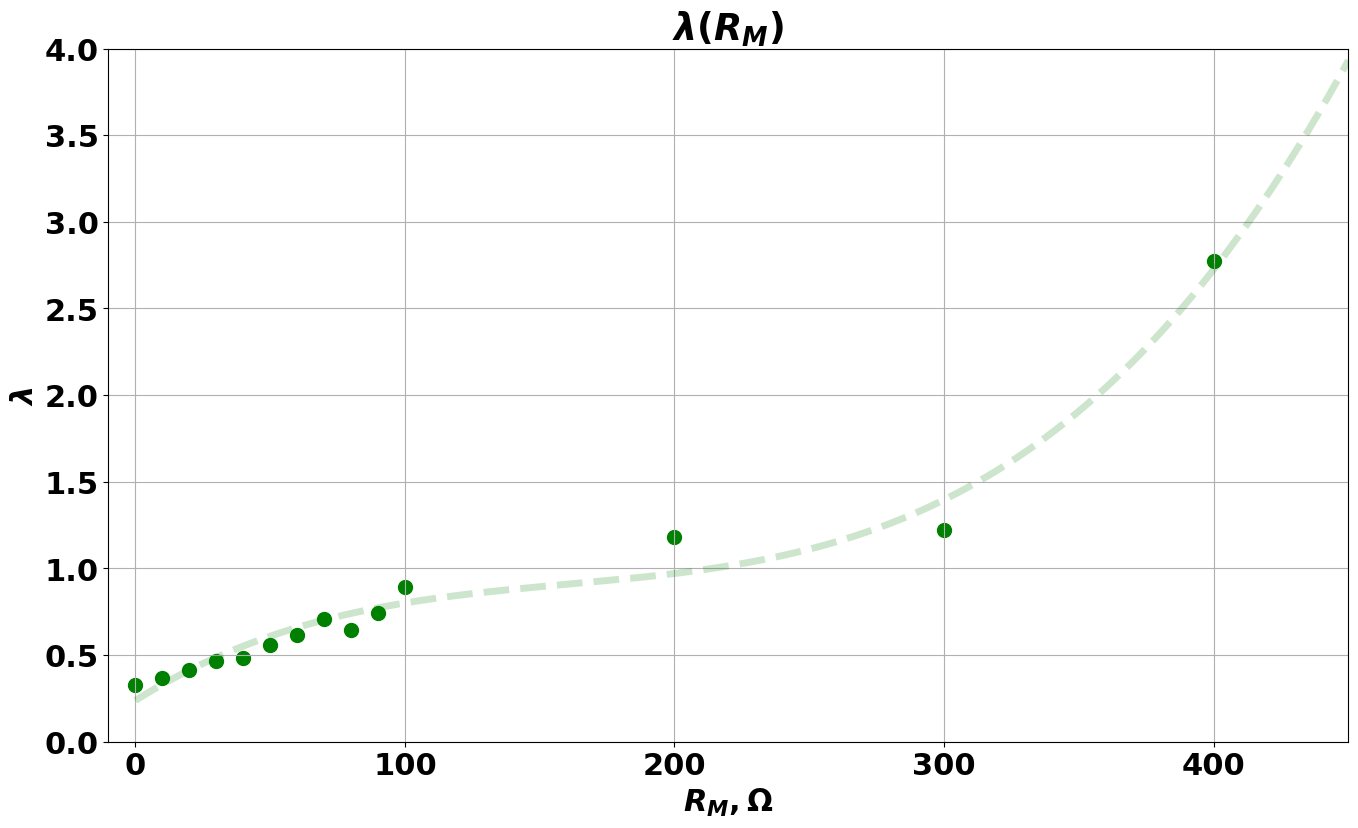

In [3]:
plt.figure(figsize=(16, 9))
x = np.linspace(0, 450, 1000)
p = np.polynomial.polynomial.Polynomial.fit(df.Rm, df.decrement, deg=3)
plt.plot(x, p(x), c='g', alpha=.2, linewidth=5, linestyle='--',)
plt.scatter(df.Rm, df.decrement, c='g', s=100)
plt.ylabel(r'$\lambda$')
plt.xlabel(r'$R_{M}, \Omega$')
plt.xlim(-10, 450)
plt.ylim(0, 4)
plt.grid()
plt.title(r'$\lambda(R_{M})$')
plt.savefig('plots/lambda(Rm)')
plt.show()


In [4]:
from scipy.stats import linregress
lr = linregress(df.Rm[:11], df.decrement[:11])
slope = lr.slope
intercept = lr.intercept
R0 = 0
for val in np.linspace(-65, -55, 10000):
    if np.abs(slope * val + intercept) <= .00001:
        R0 = -val
        break
R0


60.355535553555356

In [5]:
df['R'] = df.Rm + R0
df['L'] = (((np.pi * df.R) ** 2) * c1) / (df.decrement ** 2)
Lmean = df.L[:11].mean()

df['T_evaluated'] = (2 * np.pi) / np.sqrt((1 / (df.L * c1)
                                           ) - ((df.R ** 2) / (4 * (df.L ** 2))))


In [7]:
df.L[:11].mean()


0.008330301319579243

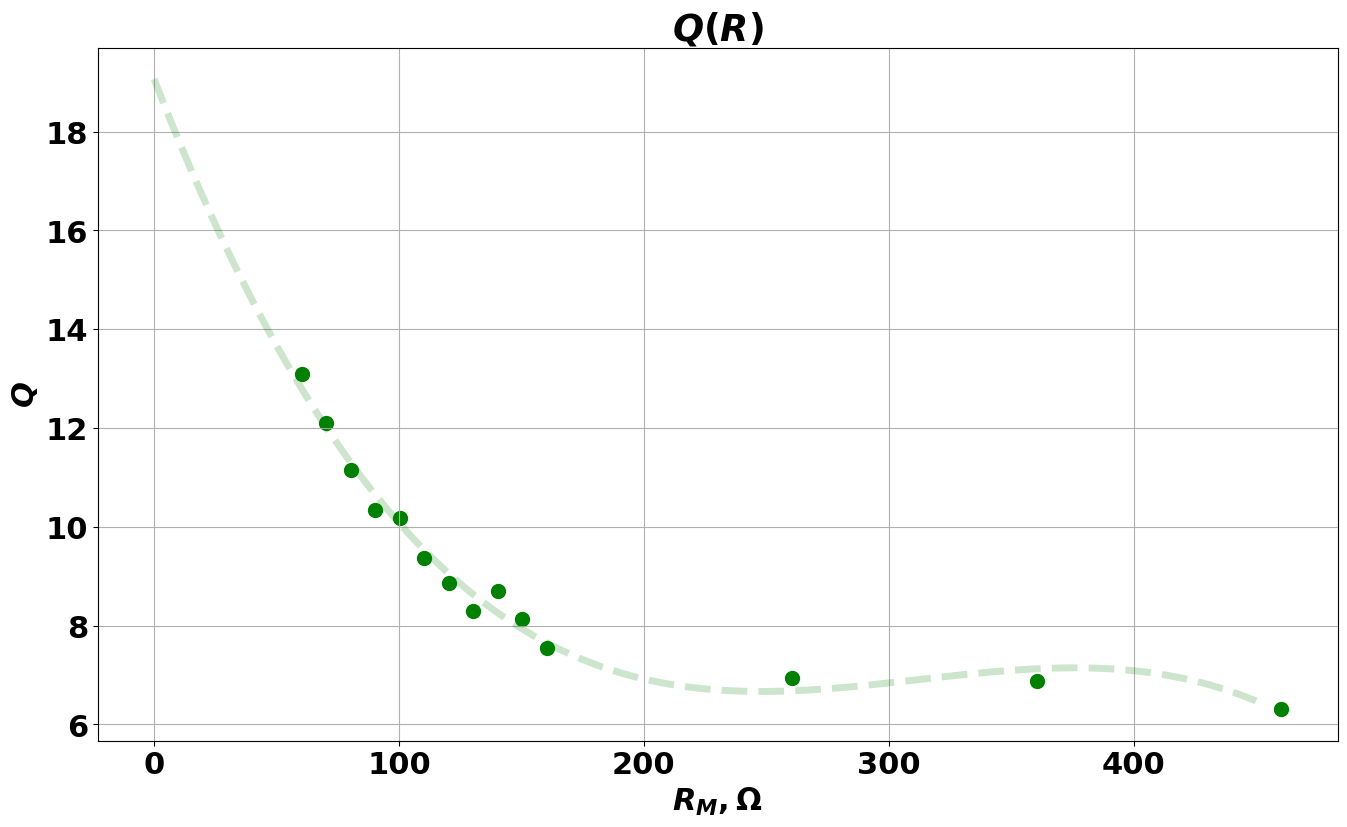

In [8]:
df['Q'] = (2 * np.pi) / (1 - np.exp(-2 * df.decrement))
plt.figure(figsize=(16, 9))
x = np.linspace(0, 450, 1000)
p = np.polynomial.polynomial.Polynomial.fit(df.R, df.Q, deg=3)
plt.plot(x, p(x), c='g', alpha=.2, linewidth=5, linestyle='--',)
plt.scatter(df.R, df.Q, c='g', s=100)
plt.ylabel(r'$Q$')
plt.xlabel(r'$R_{M}, \Omega$')
plt.grid()
plt.title(r'$Q(R)$')
plt.savefig('plots/Q(R).png')
plt.show()


In [9]:
def thompson(L, C):
    return 2 * np.pi * np.sqrt(L * C)

cdf['T_theor'] = (2 * np.pi) / (np.sqrt((1 / (Lmean * cdf.C)) - ((R0 / (2 * Lmean)) ** 2)))
cdf['deltaT'] = (cdf.T_exp - cdf.T_theor) / (cdf.T_theor)
cdf['T_thompson'] = thompson(Lmean, cdf.C)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


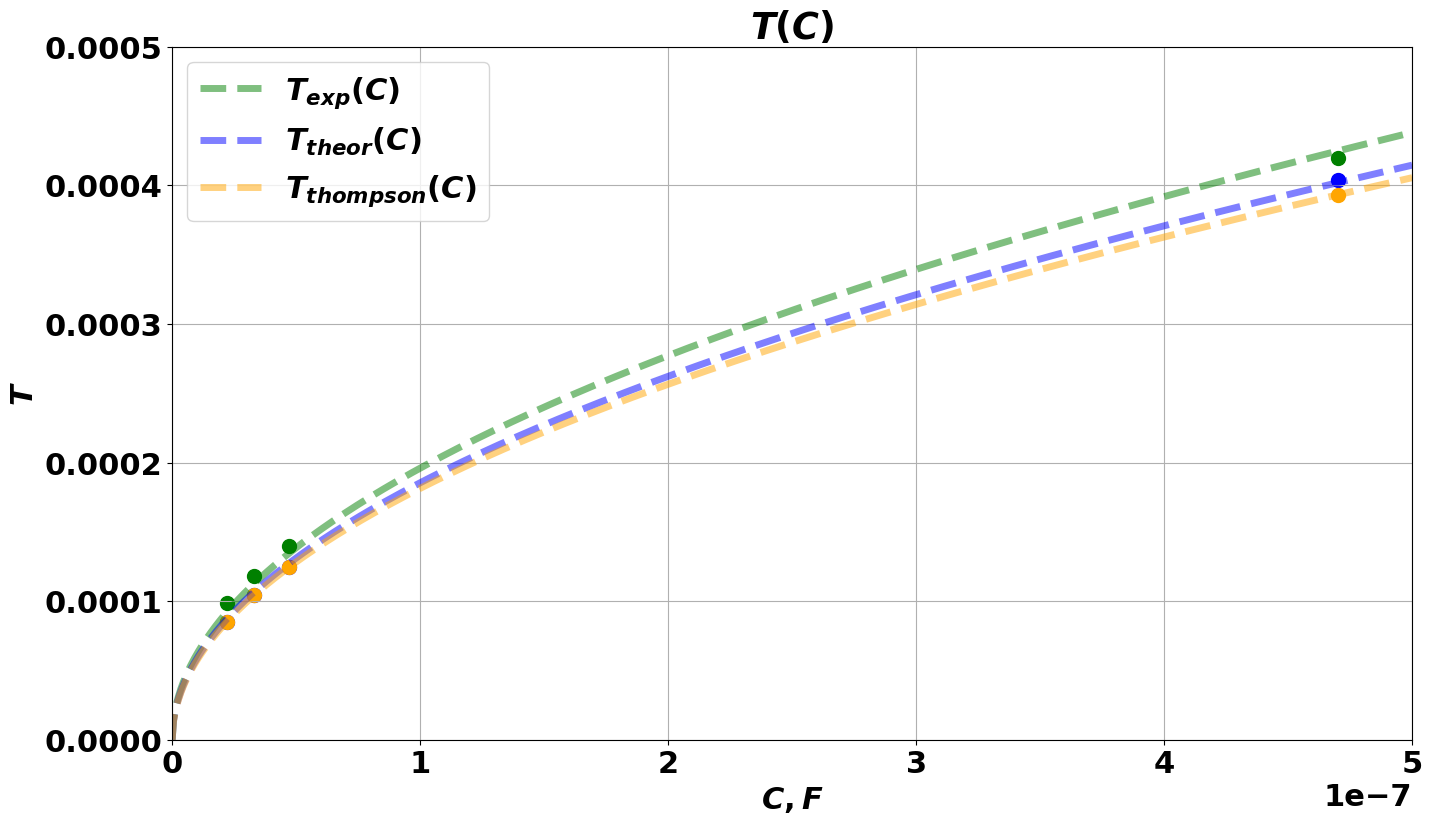

In [30]:

plt.figure(figsize=(16, 9))

def fit_func(x, a, b):
    return a * np.sqrt(b * x)

exp_a, exp_b = curve_fit(fit_func, cdf.C, cdf.T_exp)[0]
theor_a, theor_b = curve_fit(fit_func, cdf.C, cdf.T_theor)[0]
thompson_a, thompson_b = curve_fit(fit_func, cdf.C, cdf.T_thompson)[0]

x = np.linspace(0, 5 * 1e-7, 1000)

p_exp = np.polynomial.polynomial.Polynomial.fit(cdf.C, cdf.T_exp, deg=1)
p_theor = np.polynomial.polynomial.Polynomial.fit(cdf.C, cdf.T_theor, deg=2)
p_thompson = np.polynomial.polynomial.Polynomial.fit(cdf.C, cdf.T_thompson, deg=3)

# plt.plot(x, p_exp(x), c='g', alpha=.5, linewidth=5, linestyle='--', label=r'$T_{exp}(C)$')
# plt.plot(x, p_theor(x), c='blue', alpha=.5, linewidth=5, linestyle='--', label=r'$T_{theor}(C)$')
# plt.plot(x, p_thompson(x), c='orange', alpha=.5, linewidth=5, linestyle='--', label=r'$T_{thompson}(C)$')
plt.plot(x, fit_func(x, exp_a, exp_b), c='g', alpha=.5, linewidth=5, linestyle='--', label=r'$T_{exp}(C)$')
plt.plot(x, fit_func(x, theor_a, theor_b), c='blue', alpha=.5, linewidth=5, linestyle='--', label=r'$T_{theor}(C)$')
plt.plot(x, fit_func(x, thompson_a, thompson_b), c='orange', alpha=.5, linewidth=5, linestyle='--', label=r'$T_{thompson}(C)$')


plt.xlim(0, 5 * 1e-7)
plt.ylim(0, 5 * 1e-4)

plt.scatter(cdf.C, cdf.T_exp, c='g', s=100)
plt.scatter(cdf.C, cdf.T_theor, c='blue', s=100)
plt.scatter(cdf.C, cdf.T_thompson, c='orange', s=100)

plt.title(r'$T(C)$')
plt.xlabel(r'$C, F$')
plt.ylabel(r'$T$')
plt.grid()
plt.legend()

plt.savefig('plots/T(C)')
plt.show()


In [35]:
cdf['beta'] = (R0) / (2 * Lmean)
cdf['omega0'] = (1) / (np.sqrt(Lmean * cdf.C))
1 / (cdf.beta / cdf.omega0)

0    20.390689
1    16.648928
2    13.950646
3     4.411582
dtype: float64

In [41]:
df['Q2'] = (1 / df.R) * (np.sqrt(df.L / c1))

,Rm,T,Ui,Uin,n,decrement,R,L,T_evaluated,Q,Q2
0,0.0,0.000090,6.4,2.4,3.0,0.326943,60.355536,0.007400,0.000080,13.090541,9.608989
1,10.0,0.000100,6.0,2.0,3.0,0.366204,70.355536,0.008014,0.000084,12.100498,8.578803
2,20.0,0.000098,5.9,1.7,3.0,0.414775,80.355536,0.008149,0.000084,11.145257,7.574215
3,30.0,0.000099,5.7,1.4,3.0,0.467998,90.355536,0.008094,0.000084,10.337503,6.712834
4,40.0,0.000100,5.5,1.3,3.0,0.480795,100.355536,0.009460,0.000091,10.171655,6.534168
5,50.0,0.000100,5.3,1.0,3.0,0.555902,110.355536,0.008557,0.000087,9.363421,5.651340
6,60.0,0.000099,5.1,0.8,3.0,0.617461,120.355536,0.008250,0.000085,8.860254,5.087918
7,70.0,0.000098,5.0,0.6,3.0,0.706755,130.355536,0.007387,0.000081,8.303273,4.445097
8,80.0,0.000097,4.8,0.7,3.0,0.641764,140.355536,0.010386,0.000095,8.691137,4.895249
9,90.0,0.000100,4.6,0.5,3.0,0.739734,150.355536,0.008970,0.000089,8.136297,4.246919


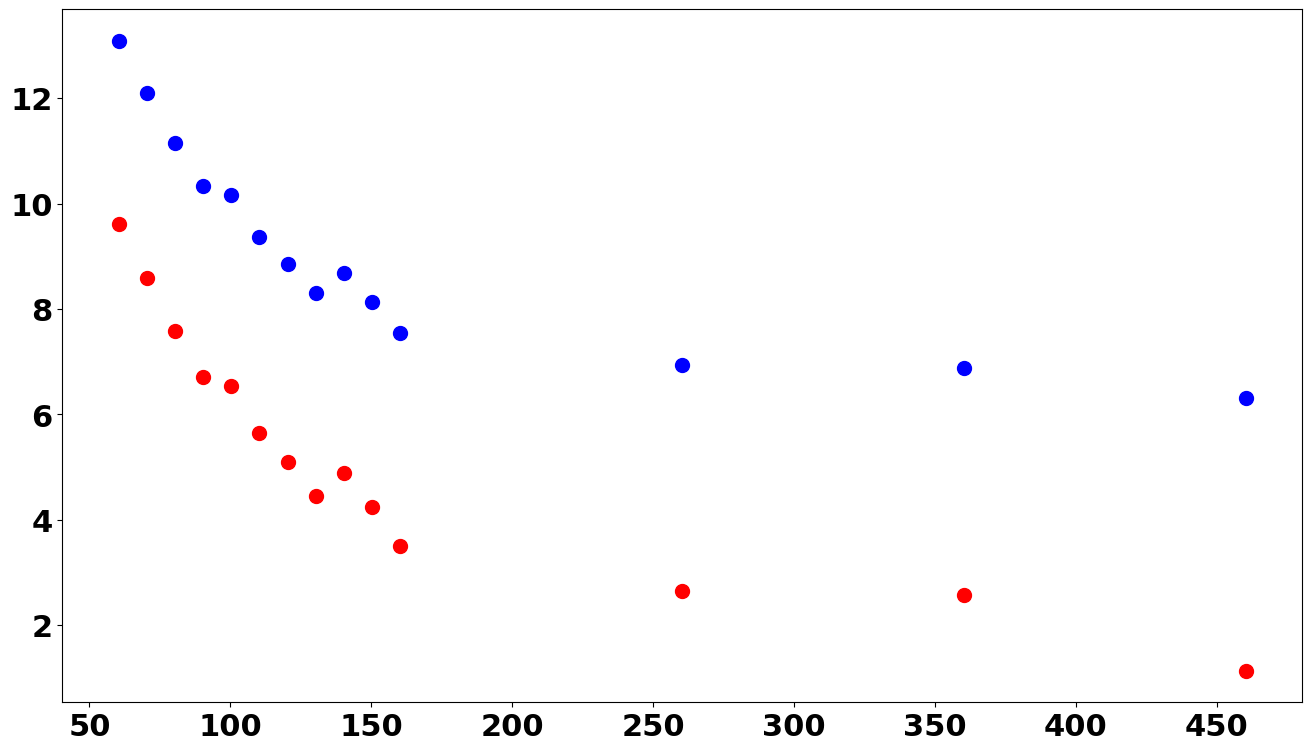

In [42]:
plt.figure(figsize=(16,9))
plt.scatter(df.R, df.Q, c='b', s=100)
plt.scatter(df.R, df.Q2, c='r', s=100)
plt.show()